# CS413 Image and Video Analysis -- Lab 7

## Department of Computer Science, University of Warwick
## August, 2019

## Aims:

+ Learn about view geometry and using the OpenCV Camera Clalibration functions
+ Understand the difference between intrinsic and extrinsic parameters, including radial distortion
+ Use calibrated images to introduce 3D geometry into the scene: scene augmentation
+ Test, using first principles, the estimation of planar homographies
+ Use planar homography to perform rectification and texture mapping
+ Use feature matching and OpenCV image perspective warping functions to mosaic images

## View Geometry and Camera Calibration

Calibrating a camera allows us to relate pixel positions in an image (or video) with 3D locations in
the scene. The only way to do this is to know the *parameters* of the camera:  the 3D position of
the camera in world coordinates, which direction it is pointing (its pose or orientation); and the
internal characteristics of the camera: its focal length and distortion parameters.

+ The position and direction of the camera are expressed as the 3D rotation and translation matrix (the
extrinsic parameters). These parameter change with the motion of the camera.

+ The focal length, aspect ratio and lens distortion of the camera are the intrinsic parameter and these
*project* the 3D world onto a 2D plane and slightly distort the image. These parameters are 
camera specific.


To calibrate a camera we need to *know* precisely 3D positions in the world and take images of it. 

The simplest and reliable way is to use a chessboard (or checkerboard) pattern and use a corner detector
to locate the 2D positions in one or more views. 

Note that each if the test pattern (checkboard) is on a flat surface and of a known size, we can find 
pairs or 3D and 2D points (if we can locate the corners precisely in the image).

Modelling and calibrating 3D scenes with videos is so fundamental in computer vision, that 
OpenCV has a built-in set of methods for camera calibration. We will go through them step-by-step.

All the images you need for this lab are in `data/camera/`.

In [8]:
import os
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

### Detecting checkboard corner points

OpenCV has a built in method to detect chessboard pattern corners. It's called `cv2.findChessboardCorners()`.

Note that we will overlay the detected corner positions using the `plt.scatter()` which plots a scatter of
`(x, y)` cooridinates. Then these can be annoated (labelled) to show the order of the points.

Here's how to do the camera calibration step, by step.


### 1. Load a camera calibraiton image containing a chessboard

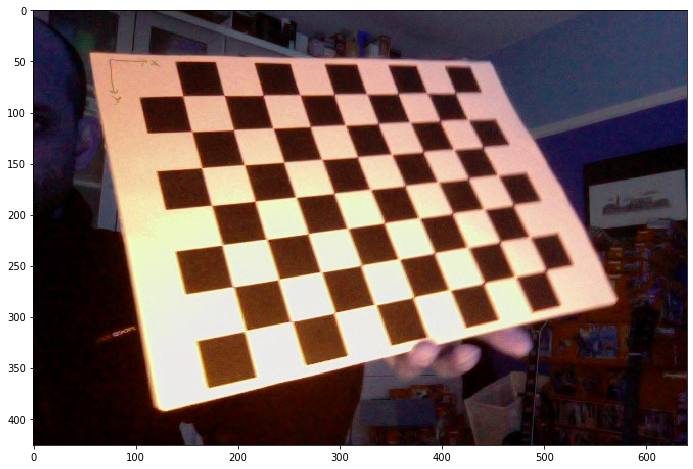

In [4]:
# input in an image which has a calibration pattern (chessboard)
data_dir = '/modules/cs413/data/camera/'

im = cv2.imread(data_dir + 'calib-2.jpg')

fig = plt.figure(figsize=(12,8))
plt.imshow(im)
plt.show()

### 2. Detect corners in the image and display the detections

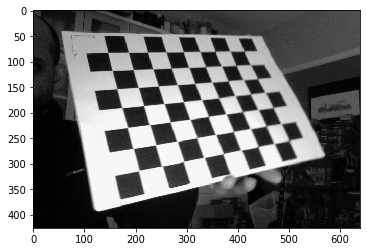

detected ok?  True
first corner is  [[146.60254   83.880585]]
(63, 2)


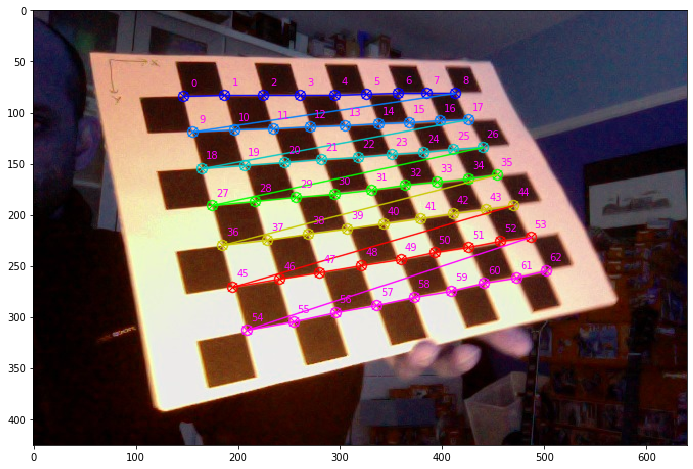

In [6]:
# find and show corners 

im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im_gray, 'gray')
plt.show()

# the second parameter is the number of squares on the board minus one in each direction
ret, corners = cv2.findChessboardCorners(im_gray, (9, 7), flags=cv2.CALIB_CB_ADAPTIVE_THRESH)

print('detected ok? ', ret)
if (ret):
    print('first corner is ', corners[0])
    
    im_corners = im.copy()
    cv2.drawChessboardCorners(im_corners, (9, 7), corners, ret)
    
    fig = plt.figure(figsize=(12,8))
    plt.imshow(im_corners)
    
    # convert to an numpy array
    np_corners = np.array(corners).reshape(len(corners),2)
    print(np_corners.shape)
    
    # label the detected corners on the checkerboard image
    labels = [str(i) for i in range(0,np_corners.shape[0])]
    k = 0
    for x, y in zip(np_corners[:,0], np_corners[:,1]): 
        plt.annotate(labels[k], # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center',
                 color=(1,0,1))
        k += 1
        
    plt.show()
else:
    print('Yikes! No corners found!!')

### 3.  Camera Calibration 

To calibrate the camera, we need to know the actually 3D positions of the detected corners.

As they are on a plane, we can measure the printed pattern and make a list of 3D locations with
$ z = 0 $ (the plane of the chessboard is nominally put at zero depth). This way we can 
enumrate the 3D positions:
    
~~~~~
    # corners in world coordinates - for a 29mm grid size 9 x 7
    corners_wc = 29 * np.mgrid[0:7,0:9].reshape(-1,2)
~~~~~

In [10]:
corners_wc = np.zeros((len(corners), 3), np.float32)
chess_square_size = 29 # in mm
print(corners.dtype)
for i in range(corners_wc.shape[0]):
    corners_wc[i,0] = chess_square_size * (i%9)
    corners_wc[i,1] = chess_square_size * (i//9)
    corners_wc[i,2] = 0.0


print(im_gray.shape[::-1])
print(corners_wc.shape)
#print(corners_wc)

# calibrateCamera can take multiple sets of corner pairs for multiple pattern images
# it returns a list of extrinsic rotation-translation vectors
# rotations are given as Euler angles and you need to use the cv2.Rodrigues function to obtain a
# matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([corners_wc], [corners], im_gray.shape, None, None)  


print('projection error is ', ret, ' RMS pixels')
print('intrinsic mtx shape is ', mtx.shape, ' values are ', mtx)
print('distortion coefficients are ', dist)
print('rvecs is ', rvecs)
extm = np.zeros((3,3))

extm, _ = cv2.Rodrigues(rvecs[0])
print('extrinsic rotation matrix is ', extm)
print('tvecs is ', tvecs)


print()

float32
(640, 426)
(63, 3)
projection error is  0.8271777700827424  RMS pixels
intrinsic mtx shape is  (3, 3)  values are  [[230.99295248   0.         154.9566033 ]
 [  0.         209.35251865 295.33377593]
 [  0.           0.           1.        ]]
distortion coefficients are  [[ 0.05637946 -0.02211421 -0.00795148  0.00206161  0.00333124]]
rvecs is  [array([[-0.19002358],
       [-0.18181653],
       [-0.20064812]])]
extrinsic rotation matrix is  [[ 0.96367461  0.2141265  -0.15962799]
 [-0.17989098  0.96216261  0.20465175]
 [ 0.19740945 -0.16850206  0.9657311 ]]
tvecs is  [array([[  -6.08310893],
       [-155.79933467],
       [ 163.31969141]])]



## Undoing lens distortion

The camera calibration will estimate the non-linear fisheye lens distortion as a set of radial distortion
coefficients $ \{k_1, k_2, k_3, k_4 \} $. 

OpenCV provides a function to *undo* the effects of the estimated distortion called `undistortImage()` and
we can apply it as follows:
    
~~~
h,  w = im_gray.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
undistorted = cv2.undistort(im_gray, mtx, dist, None, newcameramtx)
~~~

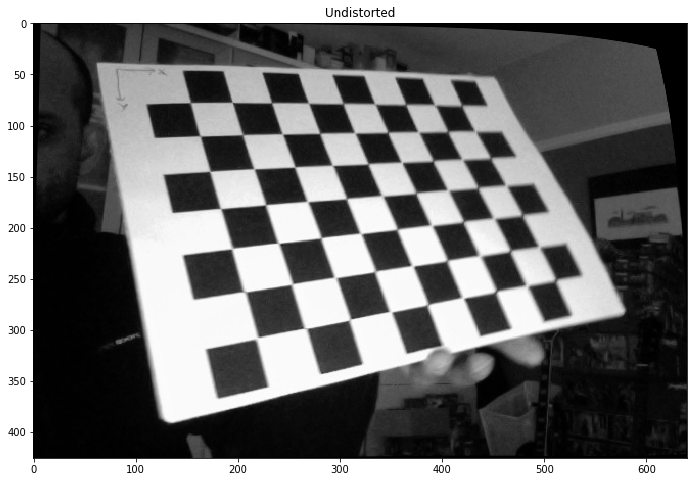

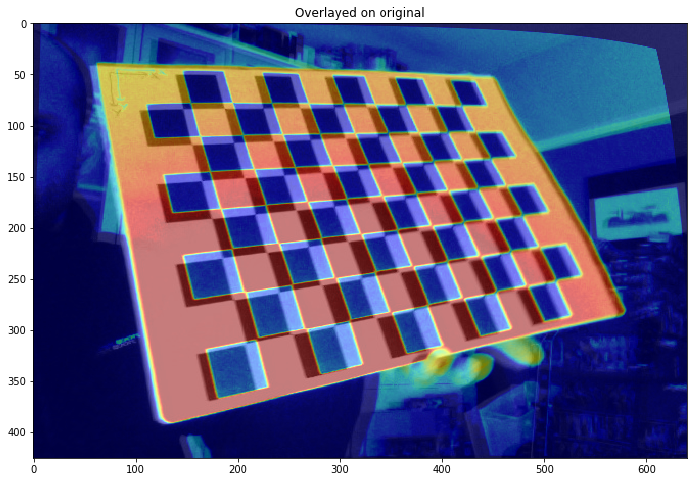

In [17]:
h,  w = im_gray.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
undistorted = cv2.undistort(im_gray, mtx, dist, None, newcameramtx)


fig = plt.figure(figsize=(12,8))
plt.imshow(undistorted, 'gray')
plt.title('Undistorted')
plt.show()

fig = plt.figure(figsize=(12,8))
plt.title('Overlayed on original')

plt.imshow(im_gray, 'gray')
plt.imshow(undistorted, 'jet', alpha=0.5)

plt.show()

#plt.imshow(undistorted, 'gray')

#plt.show()


## Exercise 1

1. Print out a copy of the camera calibration pattern `camera-calibration-checker-board_9x7.pdf` and 
calibrate your smart-phone or laptop camera 
(Note you will have to place the pattern on a flat surface like a table or glue it to a piece of card)

2. Undistort the camera calibration image from your phone

3. Undistort a different image taken from your phone



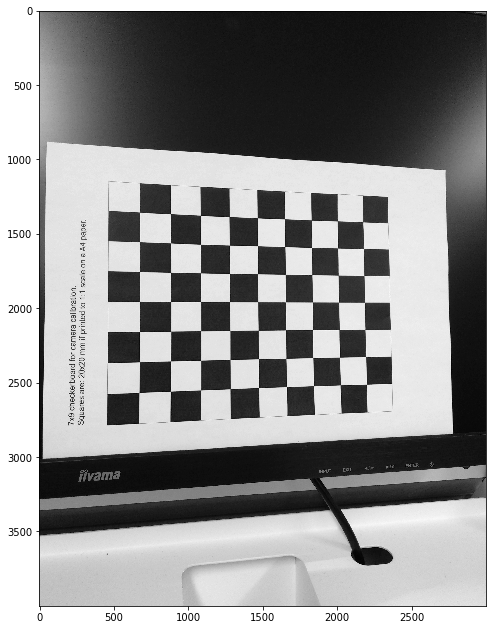

detected ok?  True
first corner is  [[ 677.9779 1359.6522]]
(63, 2)


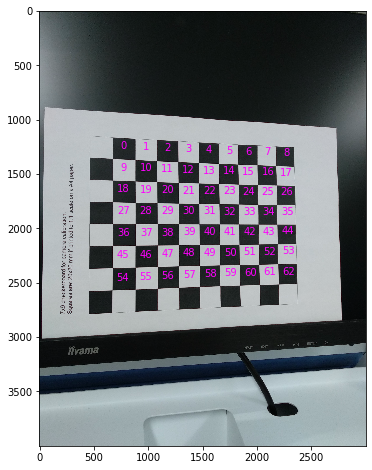

In [20]:
phon = cv2.imread('checkerboard.jpg')

fig = plt.figure(figsize=(8,12))
#plt.imshow(phon)
#plt.show()

phon_gray = cv2.cvtColor(phon, cv2.COLOR_BGR2GRAY)
plt.imshow(phon_gray, 'gray')
plt.show()

# the second parameter is the number of squares on the board minus one in each direction
ret, corners = cv2.findChessboardCorners(phon_gray, (9, 7), flags=cv2.CALIB_CB_ADAPTIVE_THRESH)

print('detected ok? ', ret)
if (ret):
    print('first corner is ', corners[0])
    
    phon_corners = phon.copy()
    cv2.drawChessboardCorners(im_corners, (9, 7), corners, ret)
    
    fig = plt.figure(figsize=(12,8))
    plt.imshow(phon_corners)
    
    # convert to an numpy array
    np_corners = np.array(corners).reshape(len(corners),2)
    print(np_corners.shape)
    
    # label the detected corners on the checkerboard image
    labels = [str(i) for i in range(0,np_corners.shape[0])]
    k = 0
    for x, y in zip(np_corners[:,0], np_corners[:,1]): 
        plt.annotate(labels[k], # this is the text
                 (x, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center',
                 color=(1,0,1))
        k += 1
        
    plt.show()
else:
    print('Yikes! No corners found!!')

In [22]:
corners_wc = np.zeros((len(corners), 3), np.float32)
chess_square_size = 29 # in mm
print(corners.dtype)
for i in range(corners_wc.shape[0]):
    corners_wc[i,0] = chess_square_size * (i%9)
    corners_wc[i,1] = chess_square_size * (i//9)
    corners_wc[i,2] = 0.0


print(phon_gray.shape[::-1])
print(corners_wc.shape)
#print(corners_wc)

# calibrateCamera can take multiple sets of corner pairs for multiple pattern images
# it returns a list of extrinsic rotation-translation vectors
# rotations are given as Euler angles and you need to use the cv2.Rodrigues function to obtain a
# matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([corners_wc], [corners], phon_gray.shape, None, None)  


print('projection error is ', ret, ' RMS pixels')
print('intrinsic mtx shape is ', mtx.shape, ' values are ', mtx)
print('distortion coefficients are ', dist)
print('rvecs is ', rvecs)
extm = np.zeros((3,3))

extm, _ = cv2.Rodrigues(rvecs[0])
print('extrinsic rotation matrix is ', extm)
print('tvecs is ', tvecs)


print()

float32
(3000, 4000)
(63, 3)
projection error is  0.8200640538400265  RMS pixels
intrinsic mtx shape is  (3, 3)  values are  [[5.96239613e+03 0.00000000e+00 2.09849318e+03]
 [0.00000000e+00 5.79157901e+03 1.50987442e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients are  [[ 0.52252208 -2.13793517 -0.03582252  0.04120732 11.36001705]]
rvecs is  [array([[-0.10198725],
       [-0.39668679],
       [ 0.00740685]])]
extrinsic rotation matrix is  [[ 0.92238693  0.01274577 -0.38605686]
 [ 0.0271486   0.99484458  0.09770989]
 [ 0.38531196 -0.10060723  0.9172856 ]]
tvecs is  [array([[-201.71532639],
       [ -20.02539793],
       [ 844.03571941]])]



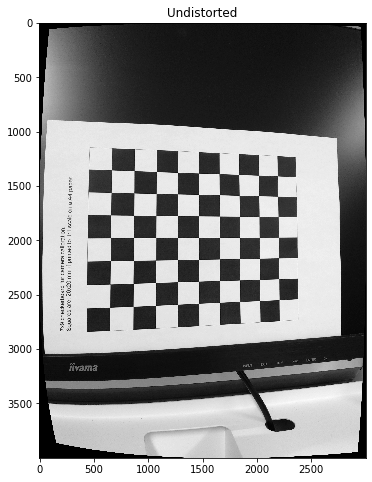

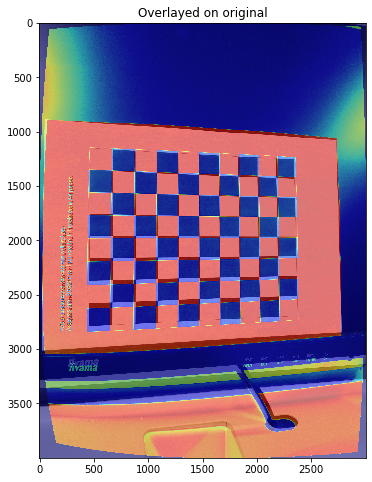

In [23]:
h,  w = phon_gray.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
undistorted = cv2.undistort(phon_gray, mtx, dist, None, newcameramtx)


fig = plt.figure(figsize=(12,8))
plt.imshow(undistorted, 'gray')
plt.title('Undistorted')
plt.show()

fig = plt.figure(figsize=(12,8))
plt.title('Overlayed on original')

plt.imshow(phon_gray, 'gray')
plt.imshow(undistorted, 'jet', alpha=0.5)

plt.show()

## Re-projection using Camera Parameters

Once a camera is calibrated, if we don't move the camera, we can augment the scene i.e.
place 3D geometry into the camera view.

We can do this directly into the camera calibration image.

First we will test this out by reprojecting the corners of the chessboard back into the image scene. How?

Well, we know that the z-positions of the chessboard is 0, and that in World Coordinates (WC), they are
at 19 mm steps (in my image), so we know that the coordinates are on a grid `(i, j)`
~~~~
    corners_wc = (19 * j, 19 * i, 0)
~~~~

OpenCV has a function `projectPoints()` which can take camera calibration paramters and project
world coordinates to image coordinates.


### Exercise 2

1. What transformations does `projectPoints` apply to project 3D world coordinates on to image coordinates?

2. Use the code below to test out different sets of world coordinates, e.g. what happens if you make
`z = 19` or `z = -19` instead of `z = 0`?

3. Try this for your own calibrated image (if you have calibrated your own camera)


(63, 2)


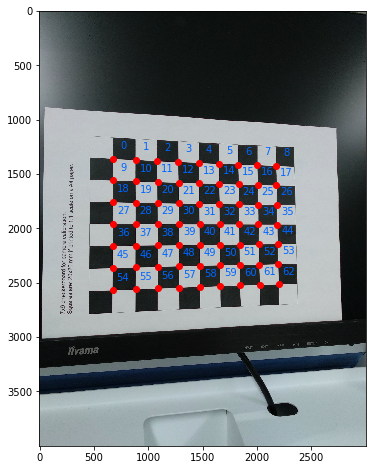

In [31]:
reproj_corners, _ = cv2.projectPoints(corners_wc, rvecs[0], tvecs[0], mtx, dist)


reproj_corners = reproj_corners.reshape(len(reproj_corners),2)
# convert to an numpy array
#np_corners = np.array(corners).reshape(len(corners),2)
print(reproj_corners.shape)

fig = plt.figure(figsize=(12,8))
plt.imshow(phon)

plt.scatter(reproj_corners[:,0], reproj_corners[:,1], color='r')
# label the detected corners on the checkerboard image
labels = [str(i) for i in range(0,reproj_corners.shape[0])]
k = 0
for x, y in zip(reproj_corners[:,0], reproj_corners[:,1]): 
    plt.annotate(labels[k], # this is the text
             (x, y), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(10,10), # distance from text to points (x,y)
             ha='center',
             color=(0,0.4,1))
    k += 1

plt.show()
    
# project reprojected points on image

## Augmenting a Calibrated Image

We can put more intresting geometry into the scene...don't get too excited it's not Avengers Endgame!

In the code below, it makes a tetrahedron object and augments the scene.

### Exercises

1. Make another solid object, like a cube or an icosahedron and autment the scene in a different position

2. If this was a movie of the chess board, how would you keep the object in the same relative position of to the
calibration pattern?



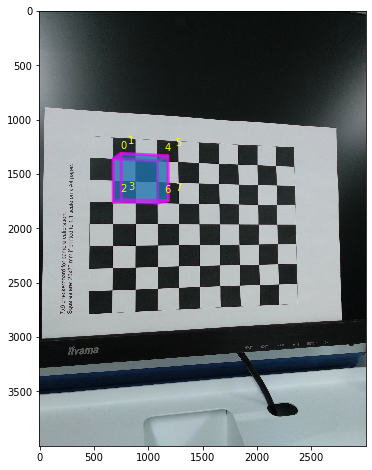

In [60]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def make_tetrahedron(size=1):
    vertices = size * np.array([[0, 0, 0], [0,0,-1],[0,1,0],[0,1,-1],[1,0,0],[1,0,-1],[1,1,0],[1,1,-1]], dtype="float")
    faces = [[0,1,3,2],[6,7,5,4],[3,2,7,6],[4,5,1,0],[6,4,0,2],[7,5,1,3]] # indices
    
    return vertices, faces

tet_wc, tet_faces = make_tetrahedron(size=2 * 29) # size given in mm

# transform from world to image coordinates
tet_ic, _ = cv2.projectPoints(tet_wc, rvecs[0], tvecs[0], mtx, dist)
# convert to an numpy array
tet_ic = tet_ic.reshape(len(tet_ic),2)


# make plot patches from tet face indices
patches = []
for i in range(len(tet_faces)):
    polygon = Polygon(tet_ic[np.array(tet_faces[i])], True)
    patches.append(polygon)
    
p = PatchCollection(patches, lw=3.0, edgecolor=(1,0,1), alpha=0.5)

# plot image and AR solid object

fig, ax  = plt.subplots(figsize=(12,8))
plt.imshow(phon)

#plt.plot(tet_ic[:,0], tet_ic[:,1])
ax.add_collection(p)

# label the detected corners on the checkerboard image
labels = [str(i) for i in range(0,tet_ic.shape[0])]
k = 0
for x, y in zip(tet_ic[:,0], tet_ic[:,1]): 
    plt.annotate(labels[k], # this is the text
             (x, y), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(10,10), # distance from text to points (x,y)
             ha='center',
             color=(1,1,0))
    k += 1

plt.show()

## Planar Homography


Homography or planar homography allows us to find a perspective transformation matrix between two images
without camera calibration. This matrix takes will transform points on a plane in one image to a plane in the other.

To estimate a homography (which is 9 parameters) we need at least 4 points in each image, which give us enough equations to solve for the unknown parameters.

From first principles, Homography is the solution to a homogeneour least-squares estimation problem of the form
$$
    A \mathbf{x} = \mathbf{0}
$$

### Experiments

There are some images of tetris shapes taken at different angles and to estimating a homography will allow us
the overlay one tetris card image onto another.

To do this, we will 

1. Find corners using SIFT (using OpenCV)

2. We will manually identify some corresponding points

3. We will set up a set of equations and solve for the homography matrix

4. We will repeat the solution using the OpenCV method `findHomography()`

5. We will transform the points and the image pixels using the `perspectiveTransform()` function in OpenCV



### 1. Finding SIFT corners on tetris card images

In [38]:
from skimage.feature import peak_local_max

# start by finding corners on two of the tetris images of the Z shape
z2 = cv2.cvtColor(plt.imread(data_dir + 'Z2.jpg'), cv2.COLOR_RGB2GRAY)
z4 = cv2.cvtColor(plt.imread(data_dir + 'Z4.jpg'), cv2.COLOR_RGB2GRAY)

z2_harris = cv2.cornerHarris(z2,7,7,0.04)
z2_corners = np.flip(peak_local_max(z2_harris, min_distance=3,threshold_abs=0.1), axis=1) # (x,y)

z4_harris = cv2.cornerHarris(z4,7,7,0.04)
z4_corners = np.flip(peak_local_max(z4_harris, min_distance=3,threshold_abs=0.1), axis=1) # (x,y)

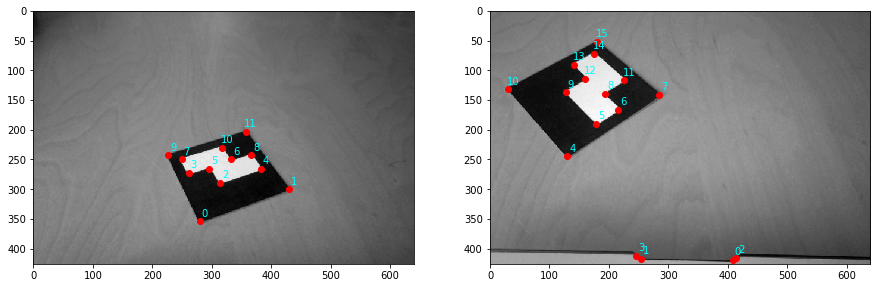

In [39]:
fig = plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(z2, 'gray')
plt.scatter(z2_corners[:,0], z2_corners[:,1], color='r')
labels = [str(i) for i in range(0,z2_corners.shape[0])]
k = 0
for x, y in zip(z2_corners[:,0], z2_corners[:,1]): 
    plt.annotate(labels[k], # this is the text
             (x, y), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(5,5), # distance from text to points (x,y)
             ha='center',
             color=(0,1,1))
    k += 1

plt.subplot(1,2,2)
plt.imshow(z4, 'gray')
plt.scatter(z4_corners[:,0], z4_corners[:,1], color='r')
labels = [str(i) for i in range(0,z4_corners.shape[0])]
k = 0
for x, y in zip(z4_corners[:,0], z4_corners[:,1]): 
    plt.annotate(labels[k], # this is the text
             (x, y), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(5,5), # distance from text to points (x,y)
             ha='center',
             color=(0,1,1))
    k += 1
plt.show()

### 2. Labelling corresponding points

In [40]:
# matches done manually Z2 -> Z4
matches = [(0,10), (1,4), (11, 7), 
           (9, 15), (2, 9), (4, 5), (8, 6), (10, 11), (7, 14), (3, 13), (5, 12)]


z2_indices = [matches[k][0] for k in range(len(matches))]
z4_indices = [matches[k][1] for k in range(len(matches))]

print('z2 indices are ', z2_indices)
print('z4 indices are ', z4_indices)

z2 indices are  [0, 1, 11, 9, 2, 4, 8, 10, 7, 3, 5]
z4 indices are  [10, 4, 7, 15, 9, 5, 6, 11, 14, 13, 12]


### 3. Set up linear equations and solve using `numpy.linalg.eig()`

In [41]:
# set up equations for homography by taking coressponding pairs of corners from two images

# set up source and destination points
src_pts = z2_corners[z2_indices]
dst_pts = z4_corners[z4_indices]

# split into x and y cordinate arrays
xs = src_pts[:,0] # x coords of source points
ys = src_pts[:,1] # y coords of source points
xd = dst_pts[:,0] # x coords of destination points
yd = dst_pts[:,1] # y coords of destination points

# now form a matrix to solve
n = len(xs)
print('there are ', n, ' point pairs')
A = np.empty((2*n,9))

for i in range(0,n):
    
    # add pairs of rows of the form
    # [ xs[i], ys[i], 1, 0,     0,     0, -xd[i]*xs[i], -xd[i]*ys[i], -xd[i] ]
    # [ 0,     0,     0, xs[i], ys[i], 1, -yd[i]*xs[i], -yd[i]*ys[i], -yd[i] ]   
    A[2*i,:]= [ xs[i], ys[i], 1, 0, 0,  0, -xd[i]*xs[i], -xd[i]*ys[i], -xd[i] ]
    A[2*i+1,:] = [ 0, 0,  0, xs[i], ys[i], 1, -yd[i]*xs[i], -yd[i]*ys[i], -yd[i] ]

print(A.shape)
S = np.matmul(A.T, A) # make square matrix

print(S.shape)
#print(S)

eig_values, eig_vectors = np.linalg.eig(S)

sort_indices = np.argsort(eig_values) #  smallest to largest
print('sorted evalues', eig_values[sort_indices])

# solution is eigen vector associated with smallest eigenvalue
m = eig_vectors[:,sort_indices[0]] # column vector of first sort index (smallest)
print(m.shape)
print(m)

H2 = m.reshape(3,3)
H2 /= H2[2,2]

print(H2) # compare this with the built in method!


there are  11  point pairs
(22, 9)
(9, 9)
sorted evalues [3.10700687e-05 1.94555753e-02 3.80277705e+03 6.82650703e+03
 2.49029936e+04 1.72364582e+05 1.90090463e+06 1.02823685e+09
 1.04725628e+11]
(9,)
[ 1.05116960e-04 -2.51480607e-03  9.19197726e-01  1.21999175e-03
  8.79462204e-04 -3.93781423e-01 -1.64302482e-06  1.81019542e-06
  1.77052536e-03]
[[ 5.93704912e-02 -1.42037281e+00  5.19166654e+02]
 [ 6.89056352e-01  4.96723868e-01 -2.22409366e+02]
 [-9.27987171e-04  1.02240581e-03  1.00000000e+00]]


### 4. Solve for Homography using OpenCV `findHomography()`

Because finding Homography is such a useful function, OpenCV has a uesful implementation and we don't
need to do it from first-principles.


Homography matrix is  [[ 6.00221566e-02 -1.42211845e+00  5.19614943e+02]
 [ 6.90379226e-01  4.98834436e-01 -2.23226032e+02]
 [-9.23491328e-04  1.02121369e-03  1.00000000e+00]]
(12, 2)
(11, 1, 2)
[[[280 354]]

 [[430 300]]

 [[357 204]]

 [[227 243]]

 [[314 289]]

 [[382 266]]

 [[366 243]]

 [[317 230]]

 [[249 250]]

 [[261 273]]

 [[296 266]]]
z2_transform_p shape is  (11, 1, 2)


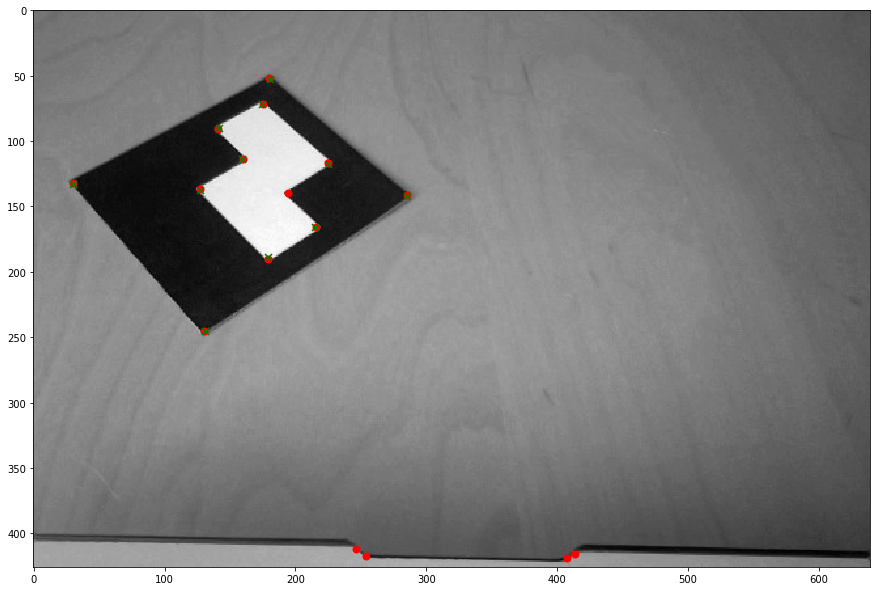

In [42]:
# we can solve for the homography using the OpenCV built-in method

H, mask = cv2.findHomography(z2_corners[z2_indices], z4_corners[z4_indices]);

print('Homography matrix is ', H)

print(z2_corners.shape)

# wrangle into the shape required by perspectiveTransform (N, 1, 2)
z2_corners_p = z2_corners[z2_indices].reshape(-1,1,2)

print(z2_corners_p.shape)
print(z2_corners_p)
z2_transformed_p = cv2.perspectiveTransform(z2_corners_p.astype('float'),  H)

print('z2_transform_p shape is ', z2_transformed_p.shape)

# plot transformed over Z4 image

z2_transformed = z2_transformed_p.reshape(z2_corners[z2_indices].shape[0], 2)

fig = plt.figure(figsize=(15,15))
plt.imshow(z4, 'gray')
plt.scatter(z4_corners[:,0], z4_corners[:,1], color='r', s=49)
plt.scatter(z2_transformed[:,0], z2_transformed[:,1], color='g', marker='x', s=49)


plt.show()

In [43]:
# compare H2 and H

print('H2 - H is', H2 - H)
print('RMSE is ', np.mean(np.square(H2.ravel()-H.ravel())) )

H2 - H is [[-6.51665422e-04  1.74564127e-03 -4.48289019e-01]
 [-1.32287396e-03 -2.11056831e-03  8.16665915e-01]
 [-4.49584237e-06  1.19212592e-06  0.00000000e+00]]
RMSE is  0.09643510419191992


### 5. Warp one image onto the other using the estimate perspective transformation H

Knowing an Homography matrix between two images allows us to map pixels from one to the other (and vice-a-versa).

OpenCV has a function called `warpPerspective` which will warp image pixels from one image to an output image (of a specified size) given the Homography matrix.


pts1 shape is  (4, 2)
[[280. 354.]
 [430. 300.]
 [357. 204.]
 [227. 243.]]
pts2 shape is  (4, 2)
[[ 30. 132.]
 [130. 245.]
 [285. 141.]
 [180.  52.]]


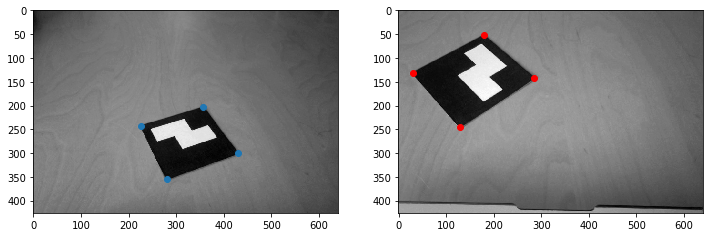

[[ 5.10073459e-02 -1.39611857e+00  5.12598668e+02]
 [ 6.72826722e-01  4.91888323e-01 -2.18839044e+02]
 [-9.60095373e-04  1.00937403e-03  1.00000000e+00]]
(426, 640) uint8


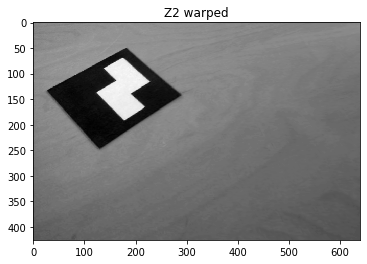

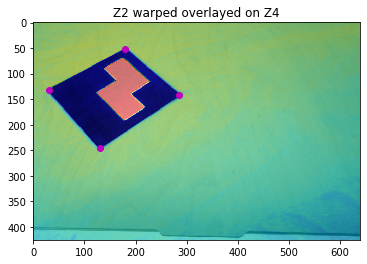

In [44]:
# warp Z2 on to Z4 frame using getPerspectiveTransform() instead of findHomography()
src = z2
dst = z4

pts1 = z2_corners[z2_indices[0:4]].astype('float32')
pts2 = z4_corners[z4_indices[0:4]].astype('float32')

print('pts1 shape is ', pts1.shape)
print(pts1)
print('pts2 shape is ', pts2.shape)
print(pts2)
fig = plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(src, 'gray')
plt.scatter(pts1[:,0], pts1[:,1])
plt.subplot(1,2,2)
plt.imshow(dst, 'gray')
plt.scatter(pts2[:,0], pts2[:,1], color='r')
plt.show()

M = cv2.getPerspectiveTransform(pts1, pts2)

print(M)

print(z2.shape, z2.dtype)

# we can use H or M here
dst_2 = cv2.warpPerspective(src, H, (dst.shape[1], dst.shape[0]))

plt.title('Z2 warped')
plt.imshow(dst_2, 'gray')
#plt.scatter(pts2[:,0], pts2[:,1], color='m')
plt.show()

plt.title('Z2 warped overlayed on Z4')
plt.imshow(dst, 'gray')
plt.imshow(dst_2, 'jet', alpha=0.5)
plt.scatter(pts2[:,0], pts2[:,1], color='m')
plt.show()

#plt.imshow(dst, 'gray', alpha=0.5)
#plt.show()

## Image Mosaicing (Stitching)

We can use homography estimation to mosaic or stitch together separate images together to produce
a panoramic image. Most smartphones have this technique built in and they do this rapidly on
movie frames.

How do we do it? 

To run the experiements, there are several images taken in Venice which overlap slightly: `venice1.jpg`, `venice2.jpg` and `venice3.jpg`.

### Using homography to mosaic images

Here are the steps we need to use:

1. Load images and detect SIFT features

2. Match SIFT features to find a set of *inliers* using FLANN matcher in OpenCV

3. Take matching points and use `findHomography` to estimate the perspective transformation between the two images

4. Apply the transformation to one of the two images and overlap.


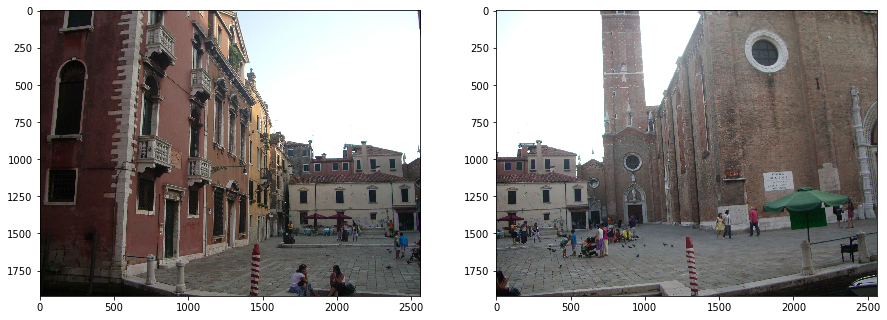

In [45]:

# Here are Steps 1 and 2...

venice1 = plt.imread(data_dir + 'venice1.jpg')
venice2 = plt.imread(data_dir + 'venice2.jpg')

fig = plt.figure(figsize=(15,10))

plt.subplot(1,2,1), plt.imshow(venice1)
plt.subplot(1,2,2), plt.imshow(venice2)

plt.show()

# find SIFT points and descriptors

sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(venice1, None)
kp2, des2 = sift.detectAndCompute(venice2, None)

num inliers are  466


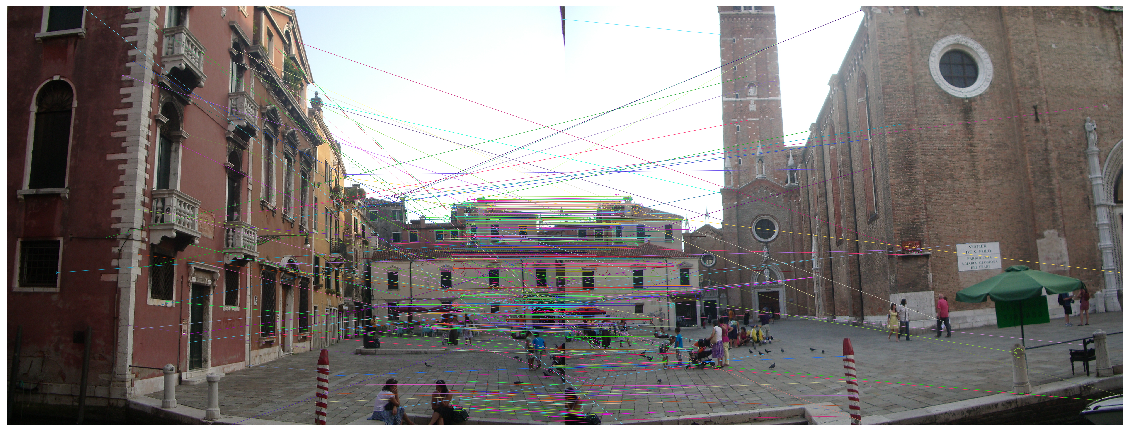

In [51]:

# we can show the 'inliers' by displaying the matches using drawKNNMatches

# use SIFT matcher and descriptors and match by taking good matches after FLANN

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

#print(matches)
# Need to draw only good matches, so create a mask

matchesMask = [[0,0] for i in range(len(matches))]
# ratio test as per Lowe's paper

inliers = 0
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance: # try lowering this to 0.4 say
        matchesMask[i]=[1,0]
        inliers += 1
        
print('num inliers are ', inliers)
draw_params = dict(#matchColor = (0,255,0),
                   singlePointColor = (255,120,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS+
                           cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS) # don't draw lone points

venice_matches_im = cv2.drawMatchesKnn(venice1,kp1,venice2,kp2,matches,None,**draw_params)


fig = plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(venice_matches_im,),plt.show()


# write out the matches image
plt.imsave('venice-matches.png', venice_matches_im)


(466, 2)
(466, 2)


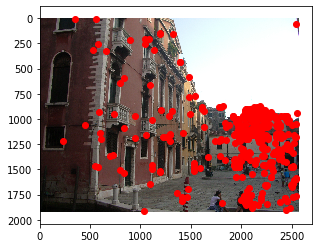

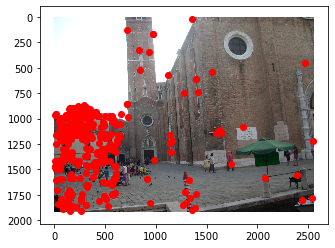

[[ 1.60875605e+00 -5.08328505e-02 -3.01980487e+03]
 [ 2.74620454e-01  1.50770623e+00 -6.02746330e+02]
 [ 2.37493160e-04 -1.24739896e-05  1.00000000e+00]]
pts2_pt shape is  (466, 1, 2)


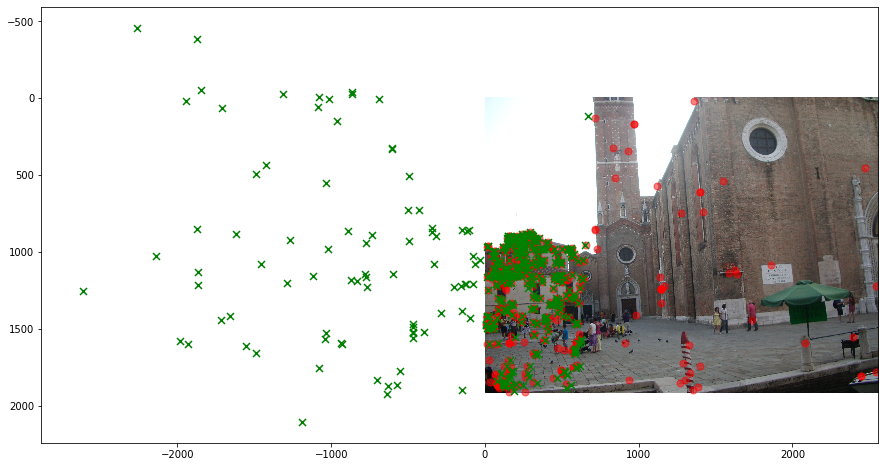

In [53]:
# Here we do Step 3 and find a homography between matched inliners

pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if matchesMask[i][0]==1: 
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
      
pts1 = np.array(pts1, dtype='float32')
pts2 = np.array(pts2, dtype='float32')


print(pts1.shape)
print(pts2.shape)

plt.imshow(venice1)
plt.scatter(pts1[:,0], pts1[:,1], color='r')
plt.show()

plt.imshow(venice2)
plt.scatter(pts2[:,0], pts2[:,1], color='r')
plt.show()

# four points only
#M2 = cv2.getPerspectiveTransform(pts1[0:4], pts2[0:4])
#print(M2)

# use RANSAC else outliers will kill the homography!

H2, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
print(H2)

# wrangle into the shape required by perspectiveTransform (N, 1, 2)
pts1_p = pts1.reshape(-1,1,2)


pts2_pt = cv2.perspectiveTransform(pts1_p.astype('float32'),  H2)

print('pts2_pt shape is ', pts2_pt.shape)

# plot transformed over Z4 image

pts2_t = pts2_pt.reshape(pts2.shape[0], 2)

fig = plt.figure(figsize=(15,15))
plt.imshow(venice2, 'gray')
plt.scatter(pts2[:,0], pts2[:,1], color='r', s=49, alpha=0.5)
plt.scatter(pts2_t[:,0], pts2_t[:,1], color='g', marker='x', s=49)
plt.show()

[[-3019.805     -602.74634 ]
 [-3193.898     2348.2913  ]
 [  631.9388    1890.7933  ]
 [  683.223       62.365128]]


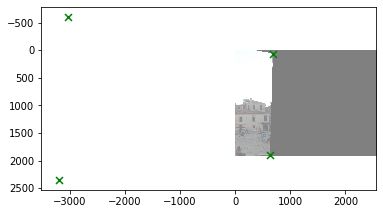

In [54]:
# ...actually the tricky bit is to find out how big the combined output will be

# make a mosaic by finding corners of where source goes and extending the output to fit both
source_corners = np.array([[0, 0], [0, venice1.shape[0]], 
                           [venice1.shape[1], venice1.shape[0]], [venice1.shape[1], 0]])
source_corners = source_corners.reshape(-1,1,2)
dstn_corners = cv2.perspectiveTransform(source_corners.astype('float32'),  H2).reshape(4,2)

print(dstn_corners)

# now do the warping as before
out_image = cv2.warpPerspective(venice1, H2, (venice2.shape[1], venice2.shape[0]))

# show the 
#plt.imshow(venice1)
plt.imshow(out_image, alpha=0.5)
plt.scatter(dstn_corners[:,0], dstn_corners[:,1], color='g', marker='x', s=49)

plt.show()



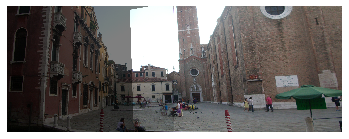

In [55]:
# The last step is to overlay pixels from one image onto the other

# it's easier to warp backwards as hence we use np.linalg.inv(H2) the inverse of H2

blend_factor = 0.5

out_image = cv2.warpPerspective(venice2, np.linalg.inv(H2), (venice1.shape[1] + venice2.shape[1], venice2.shape[0]))
out_image[0:venice1.shape[0], 0:venice1.shape[1]] = blend_factor * out_image[0:venice1.shape[0], 0:venice1.shape[1]] + (1-blend_factor) * venice1

plt.axis('off')
plt.imshow(out_image)
#plt.imshow(venice1, alpha=0.5)
#plt.scatter(dstn_corners[:,0], dstn_corners[:,1], color='g', marker='x', s=49)

plt.show()

plt.imsave('venice-mosaic.png', out_image)


### Exercise  3

Now it's your turn...

1. Take a close look at the mosaic of the two Venice examples. Why is the match good in some parts and not in others?

2. Take two images with your own phone (which have a small overlap)

3. Use the above steps to overlap them

4. How would you deal with the non-linear lens distortion?
